In [85]:
# from google.colab import drive
# drive.mount('/content/drive')

# 0. Preamble

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [87]:
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

In [88]:
data = pd.read_csv("../raw_data/global_crisis_data_country.csv", encoding='unicode_escape')
data.drop(0, inplace = True)
data.shape

(15190, 27)

In [89]:
data.rename(columns={'Banking Crisis ':'banking_crisis',
                    'Systemic Crisis':'systemic_crisis',
                    'Banking_Crisis_Notes':'notes',
                    'Currency Crises':'currency_crisis',
                    'Inflation Crises':'inflation_crisis',
                    'Gold Standard':'gold_standard',
                    'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors': 'sovereign_external_debt_1',
                    'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors': 'sovereign_external_debt_2',
                    'Inflation, Annual percentages of average consumer prices':'annual_inflation'},
            inplace = True)

data['Year'] = data['Year'].astype(int)

columns_to_convert = ['banking_crisis', 'systemic_crisis', 'annual_inflation', 'currency_crisis', 'inflation_crisis']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [90]:
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')
GDP_pc.drop(columns='417485-annotations', inplace = True)
GDP_pc.rename(columns={'GDP per capita':'GDP_per_capita'}, inplace = True)

# 1. Selecting countries for global analysis

In [91]:
from dataset import concat_dataset
from dataset import dummy_variable

In [92]:
# List of countries
OECD = ['DEU', 'AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'KOR', 'DNK', 'ESP', 'USA', 'FIN', 'FRA', 'GRC', 'HUN', 'IRL', 'ISL', 'ITA', 'JPN', 'MEX', 'NOR', 'NZL', 'NLD', 'POL', 'PRT', 'GBR', 'SWE', 'CHE', 'TUR']
G7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
G20 = ['DEU', 'CAN', 'FRA', 'GBR', 'JPN', 'ITA', 'USA', 'ZAF', 'SAU', 'RUS', 'CHN', 'ARG', 'BRA', 'IND', 'KOR', 'MEX', 'TUR', 'IDN']
UE = ['DEU', 'FRA', 'AUT', 'BEL', 'DNK', 'ESP', 'NLD', 'POL', 'PRT', 'SWE']
USA = ['USA']

#Select a list among those listed above:
countries_selected = OECD

#Create a dataset with the data of the countries of the list
global_data = concat_dataset(GDP_pc, data, countries_selected, 'left')
dummy_variable(global_data)

In [93]:
banking_crisis_only_first_year = global_data[global_data['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list
print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')

In this approch, we record 138 different crisis event.


In [94]:
global_data[global_data['Year']>1918].head(20)

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
119,23.0,DEU,Germany,1919,0.0,NaN,0.0,0,47.619,NaN,...,1,8.200000e+01,1,1,1.0,-20.27,0,1,0,0
120,23.0,DEU,Germany,1920,0.0,NaN,0.0,0,72.9927,NaN,...,1,7.630000e+01,1,1,1.0,-14.60,0,1,0,0
121,23.0,DEU,Germany,1921,0.0,NaN,0.0,0,190.1864,NaN,...,0,6.650000e+01,1,1,1.0,-7.01,0,1,0,0
122,23.0,DEU,Germany,1922,0.0,NaN,0.0,0,7352.9414,NaN,...,1,3.453200e+03,1,1,1.0,-0.59,0,1,0,0
123,23.0,DEU,Germany,1923,0.0,NaN,0.0,0,440528608,NaN,...,1,2.222019e+10,1,1,1.0,-19.06,0,1,0,0
124,23.0,DEU,Germany,1924,0.0,NaN,0.0,1,4.2016,NaN,...,1,1.810000e+01,1,1,0.0,-7.22,0,1,0,0
125,23.0,DEU,Germany,1925,0.0,NaN,0.0,1,4.2005,NaN,...,1,4.300000e+00,1,0,0.0,0.86,0,0,0,1
126,23.0,DEU,Germany,1926,0.0,NaN,0.0,1,4.2024,NaN,...,0,2.200000e+00,1,0,0.0,1.28,0,0,0,1
127,23.0,DEU,Germany,1927,0.0,NaN,0.0,1,4.1858,NaN,...,0,4.900000e+00,1,0,0.0,8.91,0,0,0,1
128,23.0,DEU,Germany,1928,0.0,NaN,0.0,1,4.196,NaN,...,0,9.000000e-01,1,0,0.0,11.17,0,0,0,1


In [95]:
from functions import crisis_duration
from functions import length_frequency

In [96]:
crisis_duration = crisis_duration(global_data)
print(crisis_duration)
print(len(crisis_duration))
print(banking_crisis_only_first_year)
print(len(banking_crisis_only_first_year))

[1, 1, 1, 4, 3, 3, 3, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 2, 1, 1, 1, 7, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 6, 7, 4, 1, 2, 6, 7, 3, 1, 2, 1, 1, 1, 1, 1, 1, 8, 4, 1, 1, 4, 1, 2, 2, 2, 1, 2, 2, 1, 1, 3, 2, 7, 7, 8, 3, 1, 1, 1, 1, 1, 2, 1, 6, 7, 5, 4, 1, 1, 1, 1, 10, 2, 1, 1, 2, 3, 5, 1, 2, 1, 1, 1, 4, 11, 1, 1, 2, 1, 7, 2, 1, 1, 1, 2, 7, 1, 4, 2, 3, 2, 2, 1, 2, 1, 1, 3, 1, 1, 8, 4, 4, 1, 1, 2, 2, 4, 1]
138
[1857, 1880, 1901, 1929, 1977, 2008, 1826, 1843, 1893, 1873, 1929, 1931, 2008, 1838, 1842, 1848, 1870, 1925, 1931, 1934, 1939, 2008, 1873, 1906, 1912, 1923, 1983, 1890, 1899, 1907, 1914, 1926, 1985, 1857, 1877, 1885, 1902, 1907, 1914, 1931, 1987, 2008, 1814, 1829, 1846, 1920, 2008, 1817, 1825, 1837, 1841, 1857, 1861, 1873, 1884, 1907, 1984, 2007, 1900, 1939, 1991, 1802, 1805, 1827, 1838, 1848, 1867, 1881, 1889, 1907, 1930, 1994, 2008, 2008, 2007, 1866, 1889, 1891, 1893, 1907, 1914, 1930, 1935, 1990, 2008, 1872, 1882, 1901, 1907, 1923, 1927, 1992, 1884, 1908, 1913, 1920, 19

In [97]:
len_freq = length_frequency(crisis_duration)
len_freq

,Length,Count,Number of points
0,1,72,138
1,2,26,66
2,3,10,40
3,4,12,30
4,5,2,18
5,6,3,16
6,7,8,13
7,8,3,5
8,10,1,2
9,11,1,1


# 2. Extracting inflation series

In [98]:
from functions import extract_inflation_series
from functions import normalize_crisis_data

In [99]:
inflation_series = extract_inflation_series(global_data)
norm_inflation_series = normalize_crisis_data(inflation_series)
len(norm_inflation_series)

138

## 2.1 Inflation response to each year of crisis

In [100]:
from visualisation import plot_by_crisis_length
from visualisation import compute_pattern

72


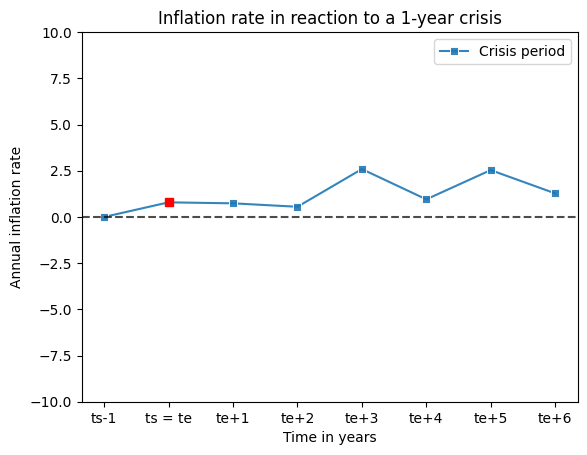

26


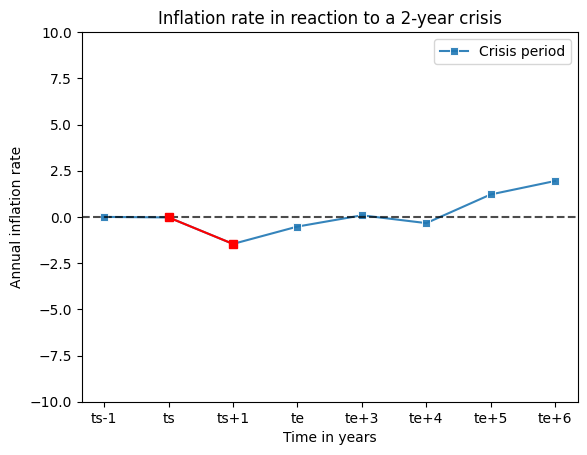

10


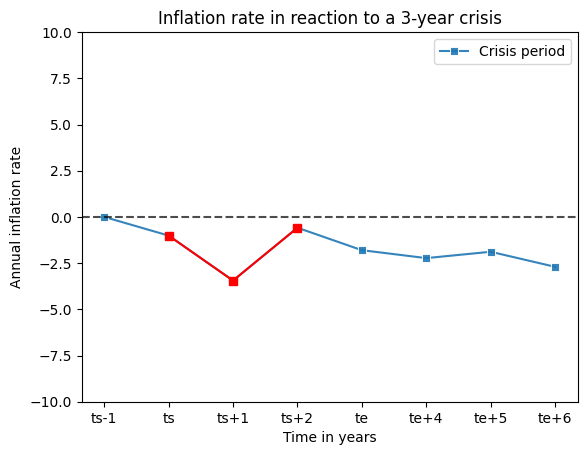

12


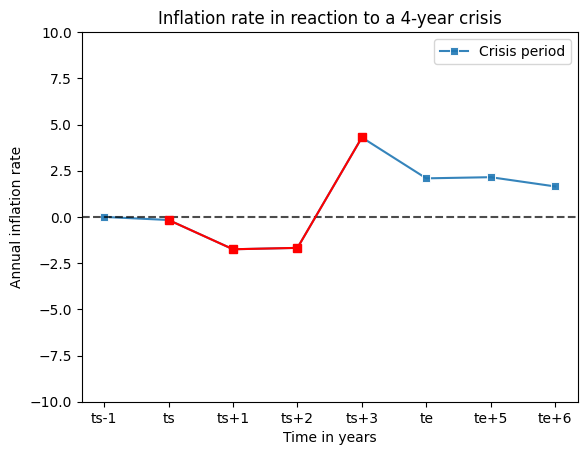

2


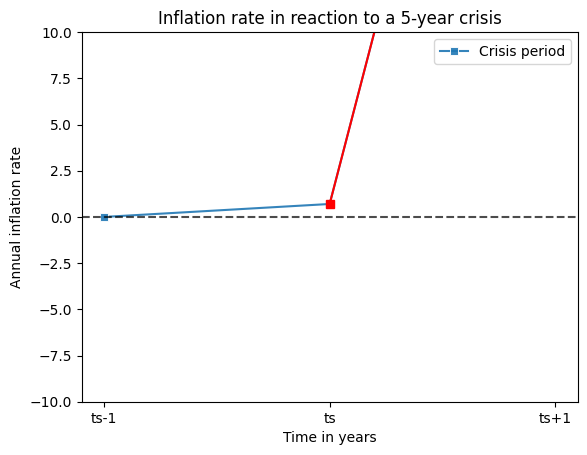

3


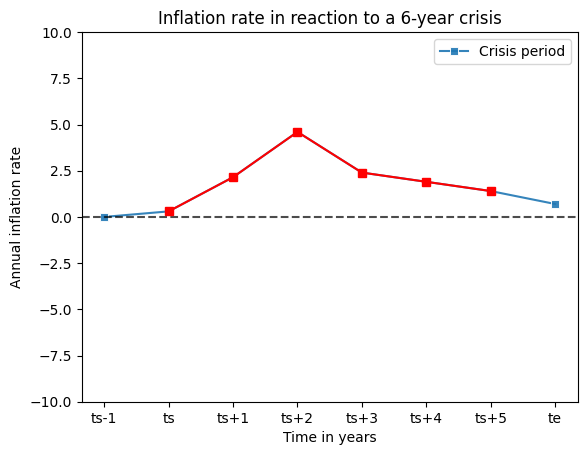

8


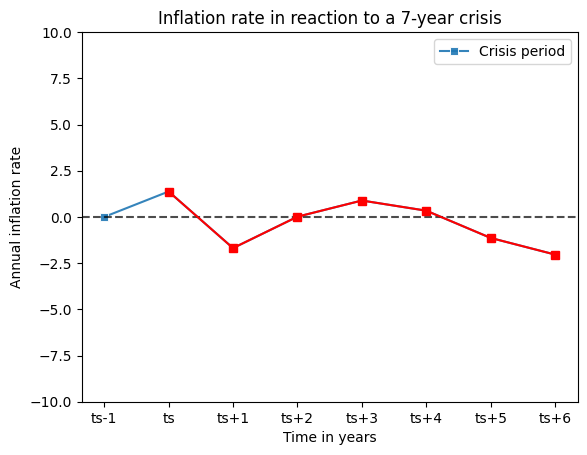

3


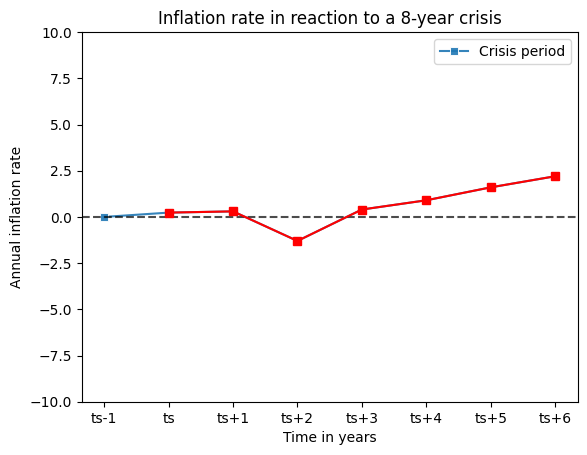

1


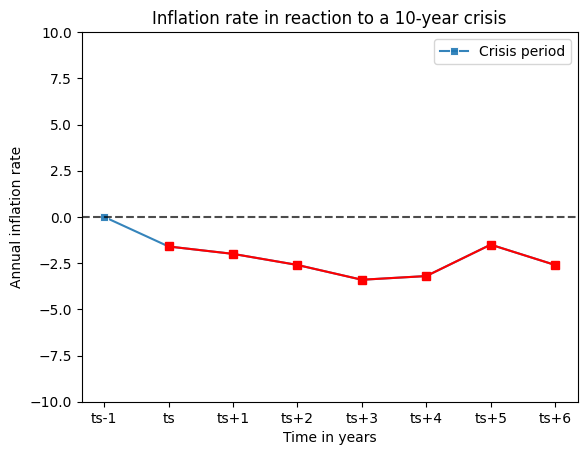

1


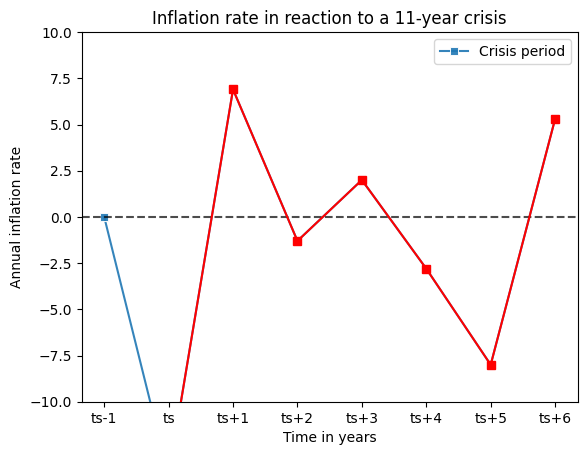

In [101]:
plot_by_crisis_length(norm_inflation_series, crisis_duration, len_freq, 'Inflation rate')

# 3. Extracting output gap series

In [102]:
from functions import extract_output_gap_series

In [103]:
global_data_inner = concat_dataset(GDP_pc, data, countries_selected, 'inner')
dummy_variable(global_data_inner)
global_data_inner

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,23.0,DEU,Germany,1800,0.0,NaN,0.0,0,3.1746,NaN,...,NaN,-12.3,1,0,0.0,-14.17,0,0,0,1
1,23.0,DEU,Germany,1820,0.0,NaN,0.0,0,2.8701,NaN,...,NaN,-4.2,1,0,0.0,-17.29,0,0,0,1
2,23.0,DEU,Germany,1850,0.0,NaN,0.0,0,2.7442,NaN,...,0,-2.9,1,0,0.0,15.58,0,0,0,1
3,23.0,DEU,Germany,1851,0.0,NaN,0.0,0,2.7255,NaN,...,0,26.3,1,0,1.0,10.18,0,1,0,0
4,23.0,DEU,Germany,1852,0.0,NaN,0.0,0,2.6936,NaN,...,0,17.2,1,0,0.0,8.09,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4717,64.0,TUR,Turkey,2012,0.0,NaN,0.0,NaN,1.796000944,1.796001,...,0,8.9,1,0,0.0,4.36,0,0,0,1
4718,64.0,TUR,Turkey,2013,0.0,NaN,0.0,NaN,1.903768242,1.903768,...,0,7.5,1,0,0.0,5.20,0,0,0,1
4719,64.0,TUR,Turkey,2014,0.0,NaN,0.0,NaN,2.188542418,2.188542,...,0,8.9,1,1,0.0,5.32,0,1,0,0
4720,64.0,TUR,Turkey,2015,NaN,NaN,0.0,NaN,2.92,2.690000,...,1,7.7,1,0,0.0,5.84,0,0,0,1


In [104]:
banking_crisis_only_first_year = global_data_inner[global_data_inner['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list

print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')

In this approch, we record 128 different crisis event.


In [105]:
crisis_duration = crisis_duration

print(crisis_duration)
print(len(crisis_duration))
print(banking_crisis_only_first_year)
print(len(banking_crisis_only_first_year))

[1, 1, 1, 4, 3, 3, 3, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 2, 1, 1, 1, 7, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 6, 7, 4, 1, 2, 6, 7, 3, 1, 2, 1, 1, 1, 1, 1, 1, 8, 4, 1, 1, 4, 1, 2, 2, 2, 1, 2, 2, 1, 1, 3, 2, 7, 7, 8, 3, 1, 1, 1, 1, 1, 2, 1, 6, 7, 5, 4, 1, 1, 1, 1, 10, 2, 1, 1, 2, 3, 5, 1, 2, 1, 1, 1, 4, 11, 1, 1, 2, 1, 7, 2, 1, 1, 1, 2, 7, 1, 4, 2, 3, 2, 2, 1, 2, 1, 1, 3, 1, 1, 8, 4, 4, 1, 1, 2, 2, 4, 1]
138
[1857, 1880, 1901, 1929, 1977, 2008, 1826, 1843, 1893, 1873, 1929, 1931, 2008, 1848, 1870, 1925, 1931, 1934, 1939, 2008, 1873, 1906, 1912, 1923, 1983, 1890, 1899, 1907, 1914, 1926, 1985, 1857, 1877, 1885, 1902, 1907, 1914, 1931, 1987, 2008, 1815, 1920, 2008, 1817, 1825, 1837, 1841, 1857, 1861, 1873, 1884, 1907, 1984, 2007, 1900, 1939, 1991, 1827, 1838, 1848, 1867, 1881, 1889, 1907, 1930, 1994, 2008, 2008, 2007, 1866, 1889, 1891, 1893, 1907, 1914, 1930, 1935, 1990, 2008, 1901, 1907, 1923, 1927, 1992, 1908, 1913, 1920, 1929, 1993, 1899, 1927, 1936, 1893, 1987, 1819, 1897, 19

In [106]:
len_freq = length_frequency(crisis_duration)
len_freq

,Length,Count,Number of points
0,1,72,138
1,2,26,66
2,3,10,40
3,4,12,30
4,5,2,18
5,6,3,16
6,7,8,13
7,8,3,5
8,10,1,2
9,11,1,1


In [107]:
output_gap_series = extract_output_gap_series(global_data_inner)
len(output_gap_series)

128

## 3.1 Output gap response for each length of crisis

68


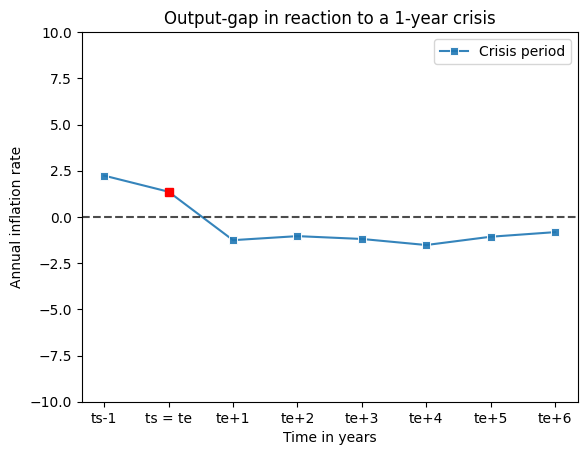

24


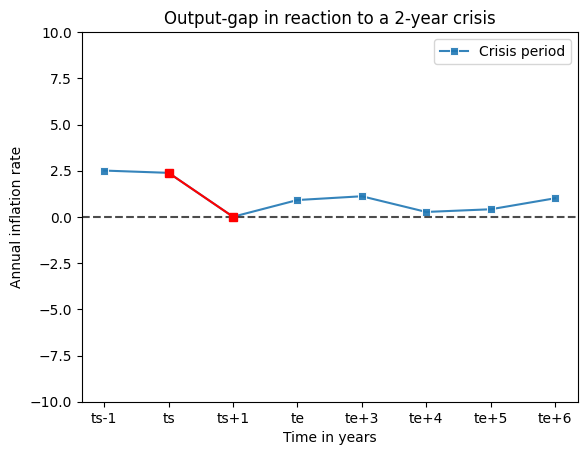

10


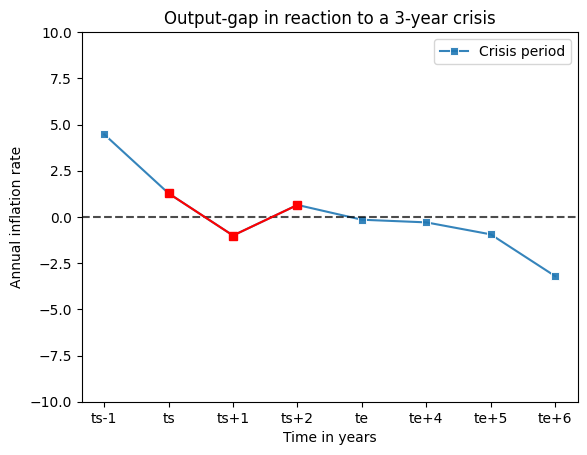

9


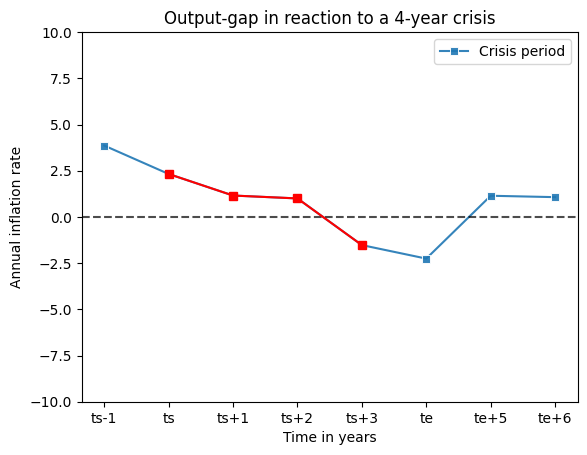

2


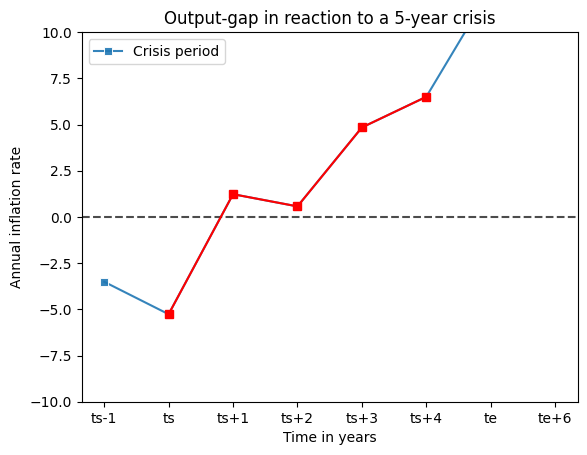

3


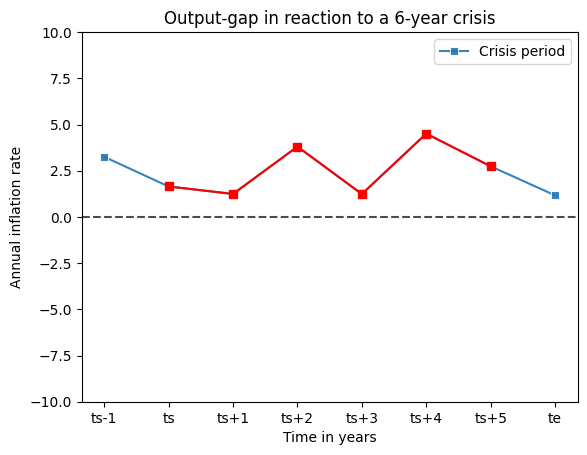

8


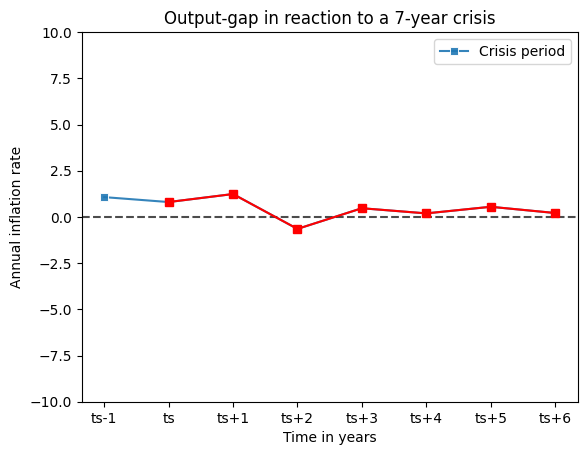

2


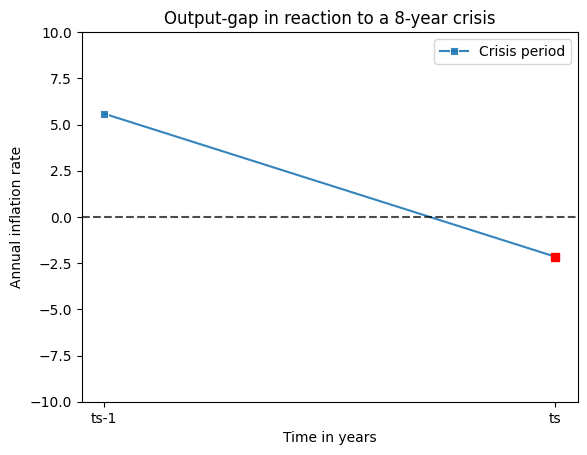

1


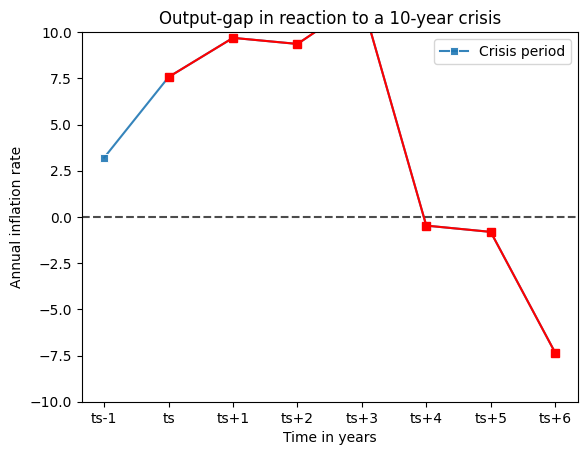

1


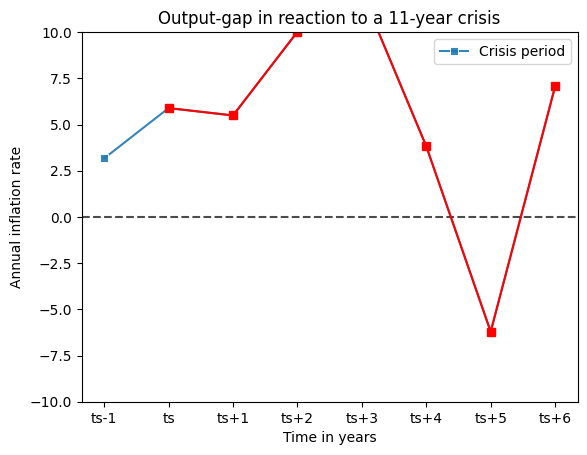

In [108]:
plot_by_crisis_length(output_gap_series, crisis_duration, len_freq, 'Output-gap')

# 4. Crisis & recovery Dynamics in a multiple country database

In [109]:
def crisis_data(data, during_crisis=True):

    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''

    series = []
    crisis_started = False
    no_crisis_period = False
    first_year_appended = False
    excluded_year_during_crisis = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['annual_inflation']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        if row['banking_crisis_only_first_year'] == 1:
                            # Append the inflation rate for the year before the crisis
                            if index - 1 >= 0:
                                current_serie.append(data.at[index - 1, 'annual_inflation'])
                            current_serie.append(row['annual_inflation'])
                            first_year_appended = True
                    else:
                        if row['banking_crisis_only'] == 1 and first_year_appended and not excluded_year_during_crisis:
                            # Continue the existing series
                            current_serie.append(row['annual_inflation'])
                        else:
                            excluded_year_during_crisis = True

                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    if len(current_serie)>0:
                        series.append(current_serie)
                    current_serie = []
                    first_year_appended = False
                    excluded_year_during_crisis = False
            else:
                # Extract data during a non-crisis period
                if row['recovery_only'] == 1:
                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['annual_inflation'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['annual_inflation'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

In [110]:
def extract_inflation_series(data):
    ''' We want here to return the series of the inflaion rate for each first year of crisis until an inflation crisis happen or another banking crisis occurs.'''
    series = []
    current_serie = []

    for index, row in data.iterrows():
        if not pd.isna(row['annual_inflation']):
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
            if row['banking_crisis_only_first_year'] == 1:
                # Extract data during a crisis
                if index - 1 >= 0:
                    current_serie.append(data.at[index - 1, 'annual_inflation'])
                current_serie.append(row['annual_inflation'])
                for i in range(1,7):
                    if data.at[index + i, 'inflation_crisis'] == 1  or pd.isna(data.at[index + i,'annual_inflation']) or data.at[index + i, 'currency_crisis'] == 1 or (data.at[index + i, 'banking_crisis'] == 1 and data.at[index + i, 'banking_crisis_only_not_first'] != 1):
                        break
                    current_serie.append(data.at[index + i,'annual_inflation'])
                series.append(current_serie)
                current_serie = []
    return series

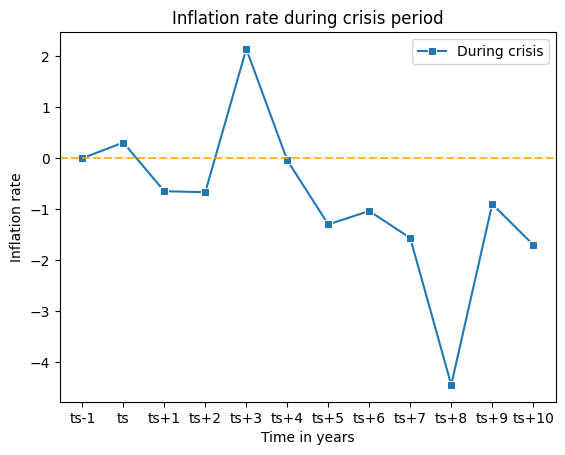

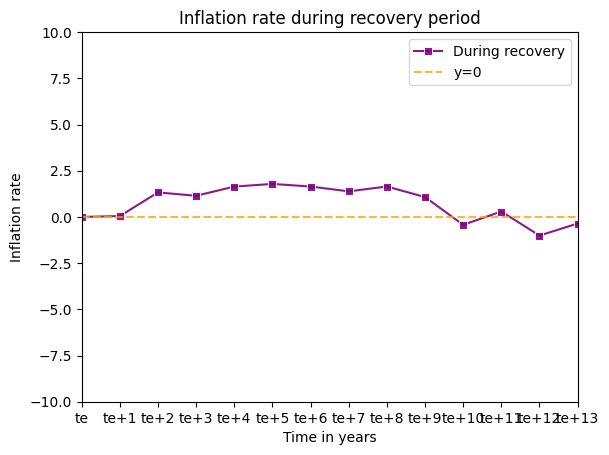

In [111]:
#Compute the average response pattern by time elapsed with normalizing the inflation series
pattern_during_crisis = compute_pattern(normalize_crisis_data(crisis_data(global_data, during_crisis = True)))
pattern_during_recovery = compute_pattern(normalize_crisis_data(crisis_data(global_data, during_crisis = False)))

#Compute the average response pattern by time elapsed without normalizing the inflation series
# pattern_during_crisis = compute_pattern(crisis_data(global_data, during_crisis = True))
# pattern_during_recovery = compute_pattern(crisis_data(global_data, during_crisis = False))

#Plot the inflation rate during banking crsis period
years = [f"ts{i}" if i < 0 else f"ts+{i}" if i > 0 else "ts" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'During crisis')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Inflation rate during crisis period')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')

plt.show()

#Plot the inflation rate during recovery period
years = [f"te+{i}" if i > 0 else "te" for i in range(0, len(pattern_during_recovery))]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'During recovery')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Inflation rate during recovery period')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')
plt.ylim(-10, 10)
plt.xlim('te', 'te+13')
plt.legend()

plt.show()

In [84]:
a = []
len(a)

0

In [54]:
crisis_data(global_data, during_crisis = True)

[[-1.1, 0.0, 2.2, 4.3],
 [2.0, 1.9],
 [2.8, 0.0],
 [-0.9, -1.9],
 [0.9, 5.5],
 [0.0, 0.0],
 [2.1, -11.2, -3.7],
 [-6.6, 8.3],
 [6.2, 6.4, 6.2],
 [2.0, 3.5, 0.8, 1.6, 2.9, 3.3, 1.2, 0.2]]

In [ ]:
def output_crisis_data(data, during_crisis=True):
    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''
    series = []
    crisis_started = False
    no_crisis_period = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['output_gap']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis_only'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        # Append the inflation rate for the year before the crisis
                        if index - 1 >= 0:
                            current_serie.append(data.at[index - 1, 'output_gap'])
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    series.append(current_serie)
                    current_serie = []
            else:
                # Extract data during a non-crisis period
                if row['recovery_only'] == 1:

                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

In [ ]:
pattern_during_crisis = compute_pattern(output_crisis_data(global_data_inner, during_crisis = True))
pattern_during_recovery = compute_pattern(output_crisis_data(global_data_inner, during_crisis = False))

years = [f"ts{i}" if i < 0 else f"ts+{i}" if i > 0 else "ts" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'Crisis period')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Output-gap during crisis period ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')

plt.show()

years = [f"te+{i}" if i > 0 else "te" for i in range(0, len(pattern_during_recovery))]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'Recovery period')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Output gap during recovery period ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')
plt.xlim('te', 'te+13')

plt.show()